In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../data_modules')
import spikeoutputs as so
import spikeplots as sp
import meaqc

Here I am loading a dataset from my SSD. Feel free to load this same one from the NAS array or any different one.

In [3]:
str_experiment = '20240717C'
d_meta = {'str_experiment': str_experiment,
          'str_protocol': 'PresentJitterImages',
          'str_algo': 'kilosort2.5',
          'paramsfile': '/Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5.params',
          'dataset_name': 'kilosort2.5',
          'str_classification': '/Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/vr_kilosort2.5.classification.txt',
          'ls_RGC_labels': ['OffP', 'OffM', 'OnP', 'OnM'],
          'str_chunk': 'chunk3',
          'ls_filenames': ['data014', 'data015', 'data016', 'data017'],
          'ls_noise_filenames': ['data012'],
          'paramsmatfile': '/Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5_params.mat'}
data = so.SpikeOutputs(**d_meta)
data.load_sta_from_params(load_ei=True, load_neurons=True, isi_bin_edges=np.linspace(0,300,601))

Loading STA from /Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5.params...
Loaded STA for 458 cells.
Loading STA params from /Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5_params.mat...
Loaded STA params for 458 cells.
Loading STA ISI...
Loading ISI for manookinlab.protocols.SpatialNoise ['data012']...
Processing group 1 of 1 and block 1 of 1
Loaded ISI for 458 cells.


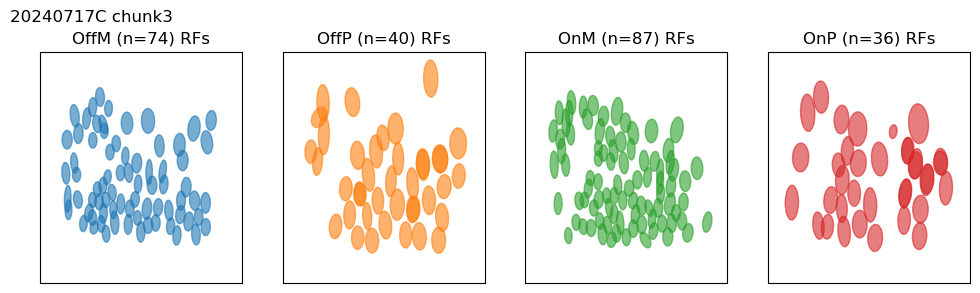

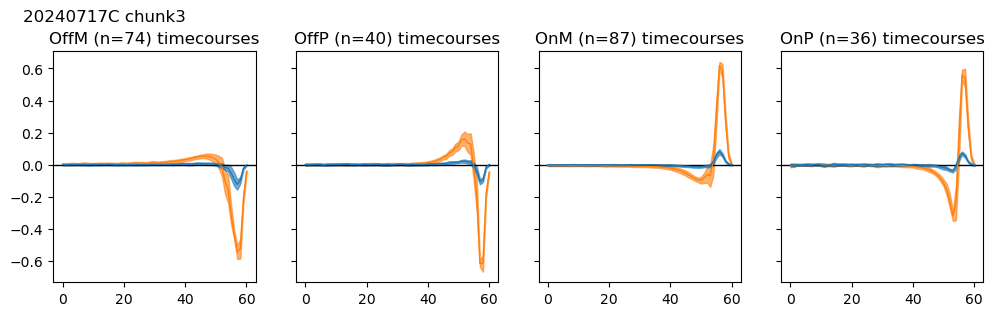

In [4]:
sp.plot_type_rfs(data, sd_mult=0.8, b_zoom=True);
sp.plot_type_tcs(data);

## QC object demo
Here I use the QC class from meaqc.py for filtering cells based on #sps and ISI violations.

In [5]:
qc = meaqc.QC(data, b_noise_only=True)

Using first 3 bins for refractory period calculation.
isi_bin_edges: [[0.  0.5]
 [0.5 1. ]
 [1.  1.5]]


Initializing the QC object will populate a `df_qc` table with properties of interest for each cell. 

Also currently, the initialization has hardcoded 1.5ms as the refractory period, based on which it sums the ISI for the 3 printed bins for calculating % refractory spikepairs.

In [6]:
qc.df_qc.head()

,cell_type,noise_spikes,noise_isi_violations,crf_f1,ei_corr
cell_id,,,,,
1.0,All/lowSNR/,8491,0.181525,NaN,NaN
4.0,OnM,49815,0.0,NaN,NaN
8.0,All/big/,25612,0.0,NaN,NaN
10.0,OffP,62857,0.00655,NaN,NaN
11.0,All/big/,32980,0.003206,NaN,NaN


crf_f1 and ei_corr are not populated by default currently.

We can look at the distributions of noise_spikes and noise_isi_violations.

(0.0, 0.1)

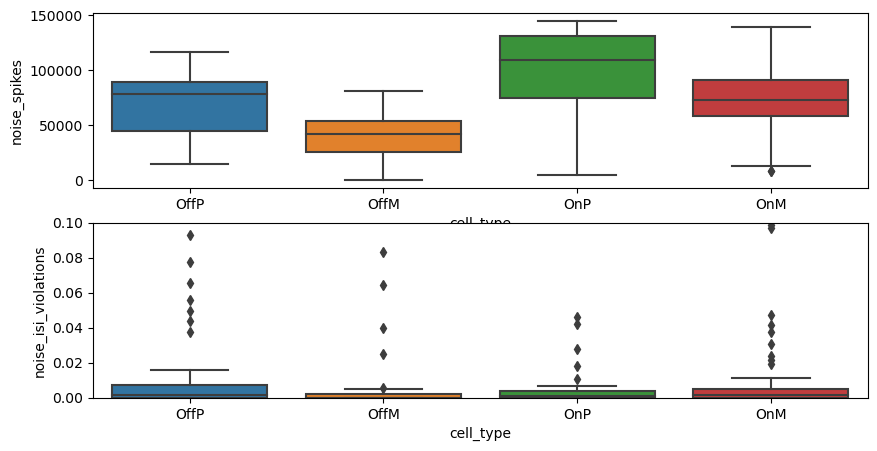

In [8]:
ls_params = ['noise_spikes', 'noise_isi_violations']
f, axs = plt.subplots(2, figsize=(10,5))
axs = axs.flatten()
for i, param in enumerate(ls_params):
    ax = axs[i]
    ax = qc.plot_dist_by_type(param, ax=ax)
axs[1].set_ylim(0,0.1)

The QC object has a dictionary for storing sets of thresholds and their consequences. By default, it is initialized with one set labeled 'set1'.

`qc.d_thresh['set1']` itself will be a dictionary containing user-set threshold values and a `df_keep` dataframe that will be populated with 0s and 1s based on thresholds.

In [14]:
qc.d_thresh.keys()

dict_keys(['set1'])

In [15]:
qc.d_thresh['set1']['df_keep'].head()

,cell_type,noise_spikes,noise_isi_violations,crf_f1,ei_corr
cell_id,,,,,
1.0,All/lowSNR/,NaN,NaN,NaN,NaN
4.0,OnM,NaN,NaN,NaN,NaN
8.0,All/big/,NaN,NaN,NaN,NaN
10.0,OffP,NaN,NaN,NaN,NaN
11.0,All/big/,NaN,NaN,NaN,NaN


## Threshold Method 1
The QC object has 2 methods for setting thresholds: 
- `set_abs_thresh`: for a specified parameter in `df_qc`, split cells based on the input `n_thresh` value. If `b_keep_below` is true than cells below the value are kept, otherwise cells above the value are kept.

In [16]:
# Keep only cells that have less than 0.01% noise ISI violations
qc.set_abs_thresh('set1', 'noise_isi_violations', 0.01, b_keep_below=True)

Now `d_thresh` will have a dictionary for that parameter with the thresholds used and summary consequences for each cell type.

In [18]:
qc.d_thresh['set1']['noise_isi_violations']

{'n_thresh': 0.01,
 'b_keep_below': True,
 'b_by_type': False,
 'n_cells': 396,
 'n_OffP': 32,
 'pct_OffP': 0.8,
 'n_OffM': 70,
 'pct_OffM': 0.9459459459459459,
 'n_OnP': 30,
 'pct_OnP': 0.8333333333333334,
 'n_OnM': 73,
 'pct_OnM': 0.8390804597701149}

This is used for visualization like so:

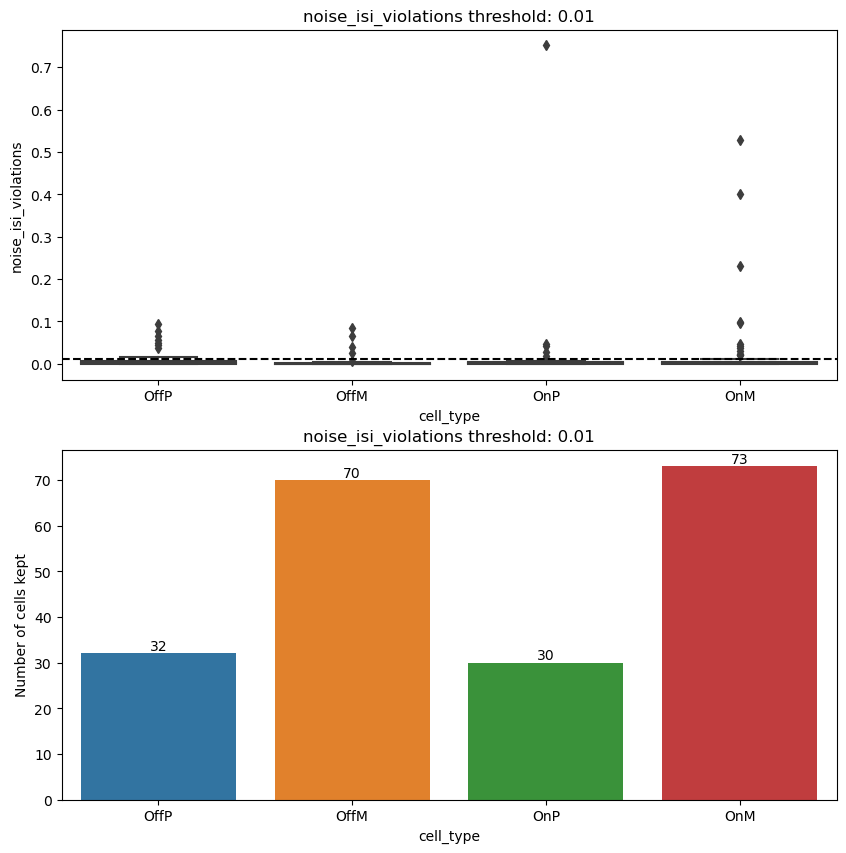

In [20]:
qc.plot_report('noise_isi_violations', 'set1');

## Threshold method 2
- `set_pct_thresh_by_type`: for a specified parameter in `df_qc`, keep the top `n_top_pct` percent of cells within each cell type.

In [21]:
qc.set_pct_thresh_by_type('set1', 'noise_spikes', n_top_pct=80)

In [22]:
qc.d_thresh['set1']['noise_spikes']

{'n_top_pct': 80,
 'b_by_type': True,
 'OffP': 43767.6,
 'n_OffP': 32,
 'pct_OffP': 0.8,
 'OffM': 19613.000000000007,
 'n_OffM': 59,
 'pct_OffM': 0.7972972972972973,
 'OnP': 62943.0,
 'n_OnP': 28,
 'pct_OnP': 0.7777777777777778,
 'OnM': 54652.4,
 'n_OnM': 69,
 'pct_OnM': 0.7931034482758621}

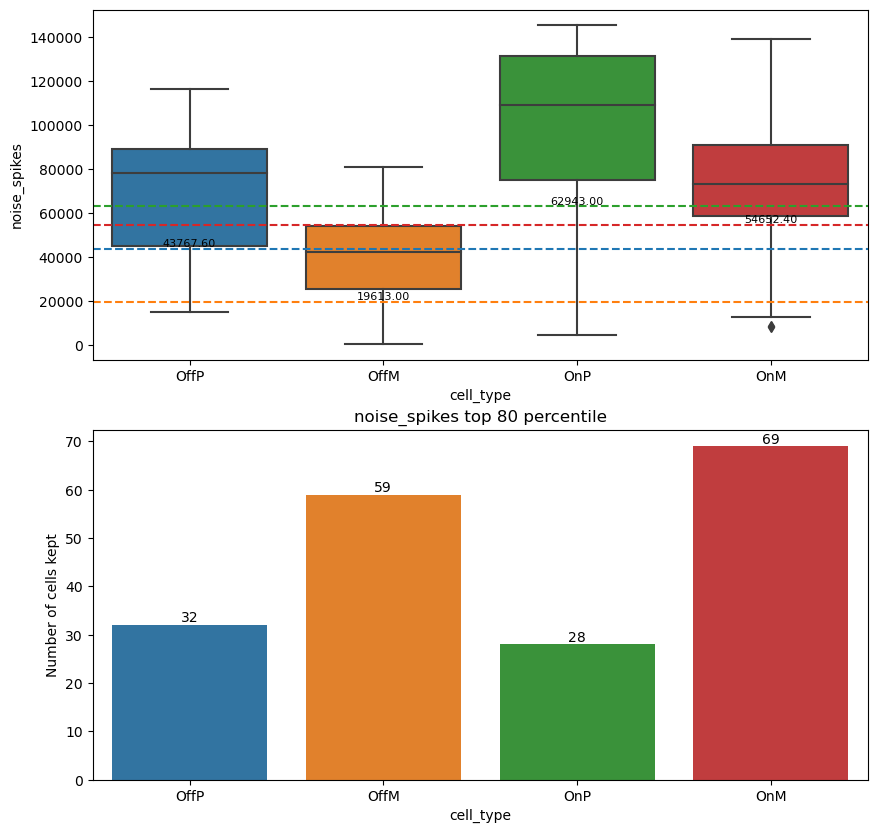

In [23]:
qc.plot_report('noise_spikes', 'set1');

## Output

We can get the cell IDs that passed the above thresholding.

In [25]:
good_cell_ids = qc.get_intersection_cells('set1')
print(f'Number of good cells: {len(good_cell_ids)}')

Number of good cells: 358


Rn I have a hackey method for updating the data object with this. Could use improvement.

In [26]:
def update_ids(good_cells, data: so.SpikeOutputs):
    data.GOOD_CELL_IDS = good_cells
    data.N_GOOD_CELLS = len(good_cells)

    # Update d_main_IDs
    for str_type in data.types.d_main_IDs.keys():
        type_ids = data.types.d_main_IDs[str_type]
        new_ids = np.intersect1d(type_ids, good_cells)
        data.types.d_main_IDs[str_type] = new_ids
        print(f'{str_type}: {len(new_ids)}/{len(type_ids)}')
    return data

data = update_ids(good_cell_ids, data)

OffP: 29/40
OffM: 56/74
OnP: 25/36
OnM: 57/87


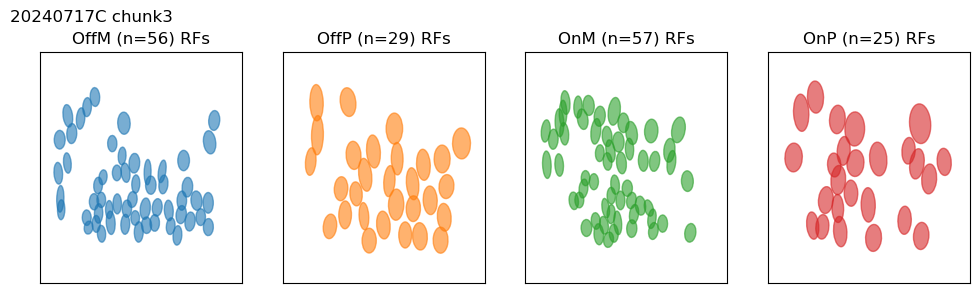

In [27]:
sp.plot_type_rfs(data, sd_mult=0.8, b_zoom=True);

Luckily enough here this gets rid of obvious duplicates.